In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import pairwise_distances_argmin_min

In [5]:
FOLDER_PATH = "F:\\user\\Google Drive\\Catherning Folder\\THU\\Thesis\\Work\\Recipe datasets"
DATASET = ["scirep-cuisines-detail","Yummly28"]
FILE = "full_data.pkl"

METHODS = ["random","cluster_centroid"] 
method = METHODS[0]
dataset = DATASET[1]

In [3]:
# FROM NN_classification
def createDFrame(file):
    
    dataset = DATASET[1]
    df = pd.read_pickle(os.path.join(
        FOLDER_PATH, dataset, file))
    df = df.set_index("id")
    len1 = len(df)

    dataset = DATASET[0]
    df2 = pd.read_pickle(os.path.join(
        FOLDER_PATH, dataset, file))
    df2["id"] = [len(df)+i for i in range(len(df2))]
    df2 = df2.set_index("id")
    df = pd.concat([df, df2],sort=False)
    if len(df)!=len1+len(df2):
        print("Error! Missing data")

    return df

df_train=createDFrame(FILE)
print(len(df_train),len(df_train[df_train["cuisine"]=="NorthAmerican"]))

84029 54022


In [4]:
54022/84029

0.6428970950505183

# Undersampling biggest class (american recipes)

https://towardsdatascience.com/sampling-techniques-for-extremely-imbalanced-data-part-i-under-sampling-a8dbc3d8d6d8

https://imbalanced-learn.readthedocs.io/en/stable/under_sampling.html

#### Random sampling

In [7]:
if method==METHODS[0]:
    american_df = df_train[df_train["cuisine"]=="NorthAmerican"].sample(frac=0.8)
    combined = df_train.append(american_df)
    df_train = combined[~combined.index.duplicated(keep=False)]
    
    #df_train = df_train[~df_train.isin(american_df).all(1)]

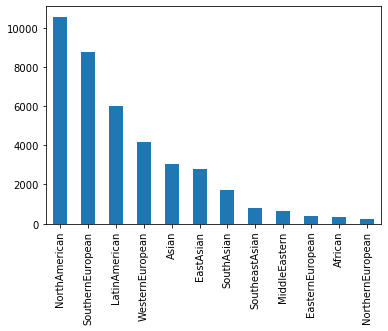

In [11]:
df_train['cuisine'].value_counts().plot(kind='bar')

In [9]:
print(len(df_train[df_train["cuisine"]=="NorthAmerican"])/len(df_train))

0.26812054126786666


In [10]:
len(df_train)

39389

#### PCA

In [48]:
if method==METHODS[1]:
    cv = CountVectorizer()

    x_american=cv.fit_transform(df_train[df_train["cuisine"]=="NorthAmerican"]['all_ingredients'].values)
    df_train.loc[df_train["cuisine"]=="NorthAmerican","american_id"]=[i for i in range(x_american.shape[0])]

In [49]:
if method==METHODS[1]:
    print(len(df_train[df_train["cuisine"]=="NorthAmerican"])*0.1)

    K_clusters=900

    reduced_data = TruncatedSVD(n_components=2).fit_transform(x_american)
    kmeans = MiniBatchKMeans(n_clusters=K_clusters, n_init=10, init_size=3*K_clusters)
    kmeans.fit(reduced_data)
    kmeans.labels_

5402.200000000001


In [50]:
if method==METHODS[1]:
    closest,_ = pairwise_distances_argmin_min(kmeans.cluster_centers_, reduced_data)
    if np.unique(closest).shape[0]!=K_clusters:
        print(np.unique(closest).shape)
        print("https://stackoverflow.com/questions/21660937/get-nearest-point-to-centroid-scikit-learn")
    
    df_train = df_train[df_train["american_id"].isin(closest) | df_train["american_id"].isnull()]

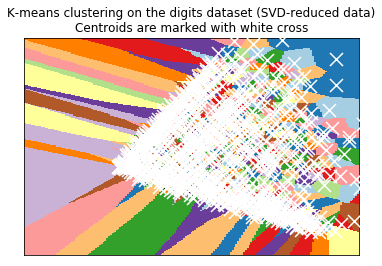

In [51]:
if method==METHODS[1]:
    reduced_data = reduced_data[:2000]

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering on the digits dataset (SVD-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [52]:
# Saving the cleaned data
df_train.to_pickle(os.path.join(FOLDER_PATH,dataset, f"{method}_data.pkl"))